In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data from the wdbc.data file
def load_data(file_path):
    columns = [
        "ID", "Diagnosis",
        "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
        "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
        "Radius SE", "Texture SE", "Perimeter SE", "Area SE", "Smoothness SE", "Compactness SE", "Concavity SE",
        "Concave Points SE", "Symmetry SE", "Fractal Dimension SE",
        "Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
        "Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
    ]
    
    data = pd.read_csv(file_path, header=None, names=columns)
    data["Diagnosis"] = data["Diagnosis"].map({"M": 1, "B": 0})  # Convert labels to binary
    return data

In [3]:
# Split the data into training and testing sets
def split_data(data, test_size=0.2):
    from sklearn.model_selection import train_test_split
    X = data.iloc[:, 2:]
    y = data.iloc[:, 1]
    return train_test_split(X, y, test_size=test_size, random_state=42)

In [4]:
# Logistic Regression implementation
class LogisticRegression:
    def __init__(self, lr=0.01, iterations=1000):
        self.lr = lr
        self.iterations = iterations

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.m, self.n = X.shape
        self.weights = np.zeros(self.n)
        self.bias = 0

        for _ in range(self.iterations):
            model = self.sigmoid(np.dot(X, self.weights) + self.bias)
            dw = (1 / self.m) * np.dot(X.T, (model - y))
            db = (1 / self.m) * np.sum(model - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        return np.where(self.sigmoid(linear_model) > 0.5, 1, 0)


In [5]:
# Decision Tree implementation
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        # For decision nodes
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        # For leaf nodes
        self.value = value

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.root = None

    def fit(self, X, y):
        self.n_classes = len(set(y))  # Number of unique classes
        self.root = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        num_samples, num_features = X.shape
        # Stopping conditions
        if num_samples == 0 or depth == self.max_depth or len(set(y)) == 1:
            return Node(value=self._most_common_label(y))
        
        # Find the best split
        best_feature, best_threshold = self._best_split(X, y)
        if best_feature is None:
            return Node(value=self._most_common_label(y))
        
        # Split the data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        return Node(feature_index=best_feature, threshold=best_threshold, left=left_child, right=right_child)

    def _best_split(self, X, y):
        best_gini = float("inf")
        best_feature, best_threshold = None, None
        num_samples, num_features = X.shape
        
        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                gini = self._gini_index(X[:, feature_index], y, threshold)
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature_index
                    best_threshold = threshold
        return best_feature, best_threshold

    def _gini_index(self, feature_column, y, threshold):
        left_indices = feature_column <= threshold
        right_indices = feature_column > threshold
        if len(left_indices) == 0 or len(right_indices) == 0:
            return 1.0  # Maximal impurity
        
        left_gini = self._gini(y[left_indices])
        right_gini = self._gini(y[right_indices])
        # Weighted Gini
        gini = (len(y[left_indices]) / len(y)) * left_gini + (len(y[right_indices]) / len(y)) * right_gini
        return gini

    def _gini(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return 1 - np.sum(probabilities**2)

    def _most_common_label(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.value is not None:  # Leaf node
            return node.value
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)


In [6]:
# Store evaluation results globally
evaluation_results = []

# Evaluation function
def evaluate(y_true, y_pred, model_name):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Save results for visualization
    evaluation_results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
    })

    print(f"\n{model_name} Accuracy:", accuracy)
    print(f"{model_name} Precision:", precision)
    print(f"{model_name} Recall:", recall)
    print(f"{model_name} F1 Score:", f1)

    # Confusion matrix visualization
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


In [7]:
# Function to visualize evaluation comparison
def visualize_comparison():
    results_df = pd.DataFrame(evaluation_results)
    results_df.set_index("Model", inplace=True)

    plt.figure(figsize=(10, 6))
    results_df.plot(kind="bar", figsize=(12, 8), colormap="Set3")
    plt.title("Model Performance Comparison")
    plt.ylabel("Score")
    plt.xlabel("Models")
    plt.xticks(rotation=45)
    plt.legend(loc="lower right")
    plt.grid(axis="y")
    plt.show()

In [8]:
# Data visualization function
def visualize_data(data):
    plt.figure(figsize=(10, 6))
    sns.countplot(x="Diagnosis", data=data, palette="Set2", hue=None)
    plt.title("Class Distribution")
    plt.xlabel("Diagnosis (0 = Benign, 1 = Malignant)")
    plt.ylabel("Count")
    plt.show()

    # plt.figure(figsize=(12, 8))
    # sns.heatmap(data.iloc[:, 2:].corr(), cmap="coolwarm")
    # plt.title("Feature Correlation Matrix")
    # plt.show()

C:\Users\a\AppData\Local\Temp\ipykernel_21408\106932455.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Diagnosis", data=data, palette="Set2", hue=None)


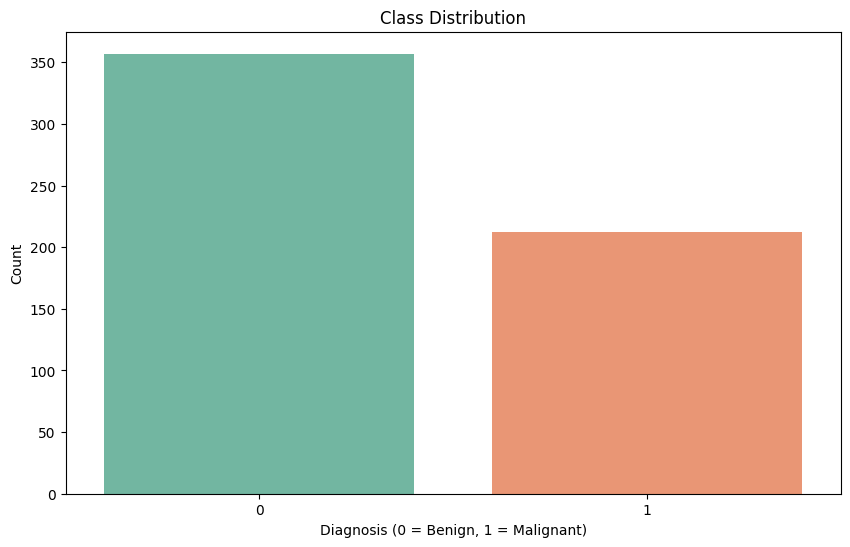


Logistic Regression (Custom Implementation):

Logistic Regression (Custom) Accuracy: 0.9473684210526315
Logistic Regression (Custom) Precision: 0.8936170212765957
Logistic Regression (Custom) Recall: 0.9767441860465116
Logistic Regression (Custom) F1 Score: 0.9333333333333333


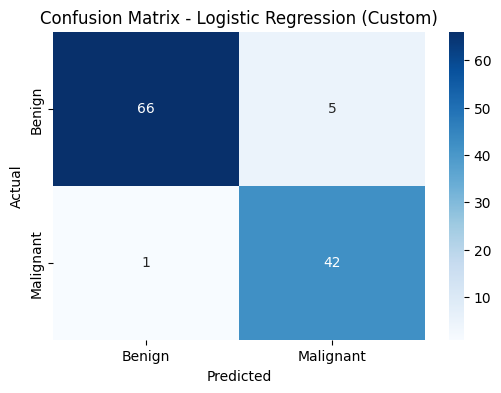


Logistic Regression (Sklearn Implementation):

Logistic Regression (Sklearn) Accuracy: 0.9736842105263158
Logistic Regression (Sklearn) Precision: 0.9761904761904762
Logistic Regression (Sklearn) Recall: 0.9534883720930233
Logistic Regression (Sklearn) F1 Score: 0.9647058823529412


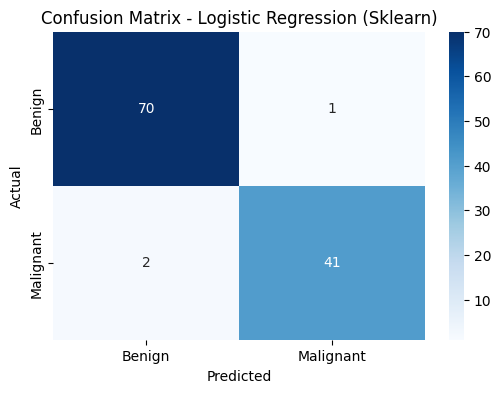


Decision Tree (Custom Implementation):

Decision Tree (Custom) Accuracy: 0.9385964912280702
Decision Tree (Custom) Precision: 0.9285714285714286
Decision Tree (Custom) Recall: 0.9069767441860465
Decision Tree (Custom) F1 Score: 0.9176470588235294


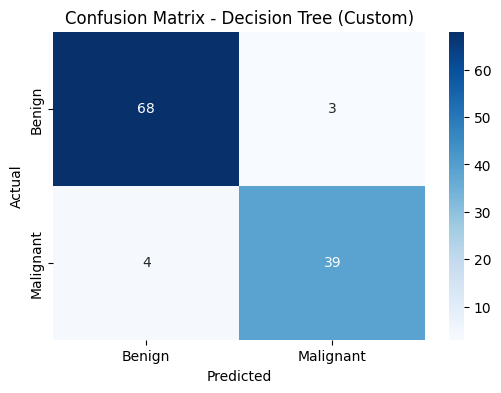


Decision Tree (Sklearn Implementation):

Decision Tree (Sklearn) Accuracy: 0.9473684210526315
Decision Tree (Sklearn) Precision: 0.9512195121951219
Decision Tree (Sklearn) Recall: 0.9069767441860465
Decision Tree (Sklearn) F1 Score: 0.9285714285714286


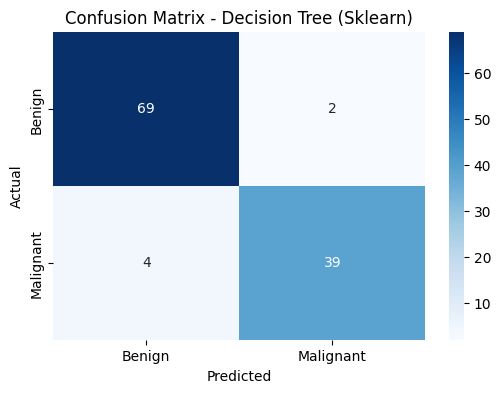

<Figure size 1000x600 with 0 Axes>

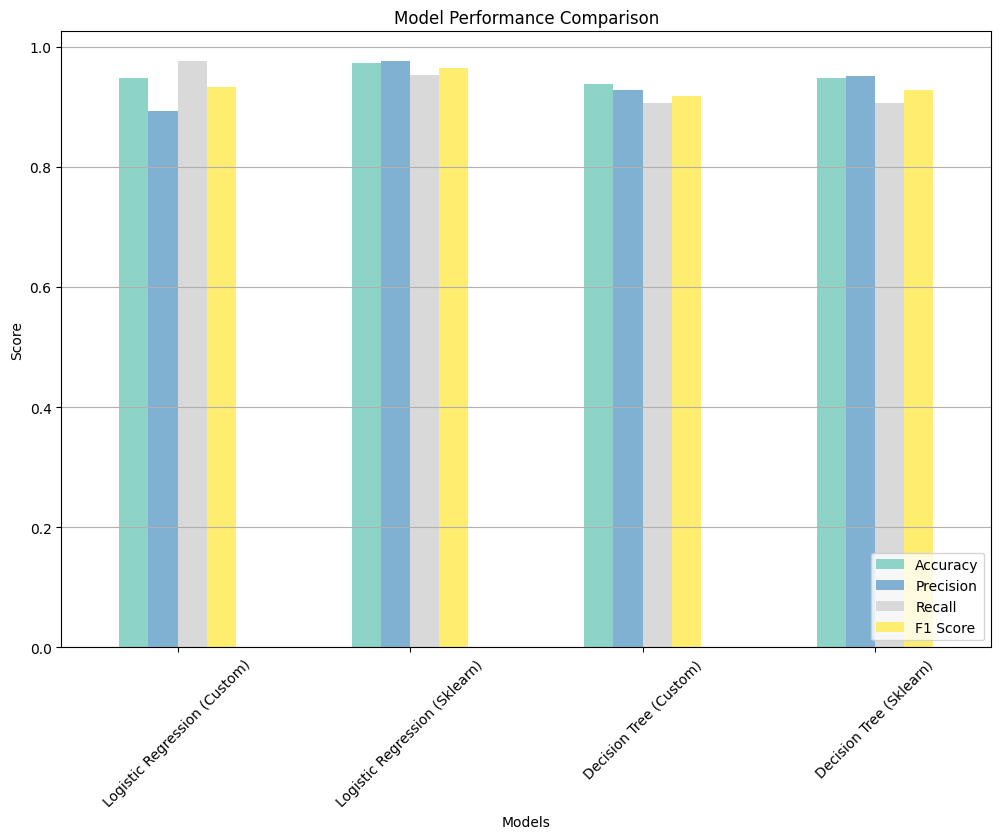

In [ ]:
# Main function
def main():
    file_path = "wdbc.data"  # 数据文件路径
    data = load_data(file_path)

    # 数据可视化
    visualize_data(data)

    # 数据拆分
    X_train, X_test, y_train, y_test = split_data(data)

    # 自定义 Logistic Regression
    print("\nLogistic Regression (Custom Implementation):")
    lr = LogisticRegression(lr=0.01, iterations=1000)
    lr.fit(X_train.values, y_train.values)
    y_pred_lr = lr.predict(X_test.values)
    evaluate(y_test, y_pred_lr, "Logistic Regression (Custom)")

    # Sklearn Logistic Regression
    print("\nLogistic Regression (Sklearn Implementation):")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
    skl_lr = SklearnLogisticRegression(max_iter=2000, random_state=42)
    skl_lr.fit(X_train_scaled, y_train)
    y_pred_skl_lr = skl_lr.predict(X_test_scaled)
    evaluate(y_test, y_pred_skl_lr, "Logistic Regression (Sklearn)")

    # 自定义 Decision Tree
    print("\nDecision Tree (Custom Implementation):")
    dt = DecisionTree(max_depth=3)
    dt.fit(X_train.values, y_train.values)
    y_pred_dt = dt.predict(X_test.values)
    evaluate(y_test, y_pred_dt, "Decision Tree (Custom)")

    # Sklearn Decision Tree
    print("\nDecision Tree (Sklearn Implementation):")
    from sklearn.tree import DecisionTreeClassifier
    skl_dt = DecisionTreeClassifier(max_depth=3, random_state=42)
    skl_dt.fit(X_train, y_train)
    y_pred_skl_dt = skl_dt.predict(X_test)
    evaluate(y_test, y_pred_skl_dt, "Decision Tree (Sklearn)")

if __name__ == "__main__":
    main()
    visualize_comparison()